# Preparation of Milestone 2

Today we will start to prepare the second milestone. The goals of this milestone are

- Implement an image classification pipeline
    - Implement a Pytorch classification dataset
    - Implement at least two custom augmentations (do not just import one from Torchvision or albumentations)
    - Implement a training and validation loop
    - Optimize your model
    - Evaluate the performance of your model with the F1 score on the test set

# Pytorch Classification Dataset 

To train neural networks in pytorch with custom datasets, custom dataset classes are needed. Today we will work on a dataset for the term project. A general introduction to custom datasets can be found [here](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html).



Your dataset must have several properties that are specific to the task:

1. Since you only have a small number of images, you will need to use image augmentation. Image augmentation is always applied on the fly. **Never apply image augmentation to images and save the augmented versions to disk for sampling!** Normally, you can use the image augmentation implemented in albumentations or torchvision. **For this project, you will need to implement two augmentations yourself**. I would suggest implementing an augmentation that applies a Gaussian blur to the image and a function that applies a color jitter to the image. Implement the augmentations in a way that they can be **composed** with other TorchVision transformations.

2. Apply minority class oversampling and majority class undersampling for better generalization. You can either implement an initialization function in your dataset where you first sample the coordinates for this epoch, or sample the coordinates on the fly in the __getitem__ method.

3. Your dataset class will inherit from torch.utils.data.Dataset. But you must override the **__len__** and **__getitem__** functions.

In [4]:
import os
import torch
import random
import numpy as np
import pandas as pd
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, Subset
from PIL import Image, ImageFilter, ImageEnhance
import matplotlib.pyplot as plt
from torch.utils.data.dataset import Subset
from sklearn.model_selection import train_test_split
import torchvision.models as models
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from torchmetrics import F1Score
import torchmetrics

Number of samples in the dataset: 19864
Number of classes: 12


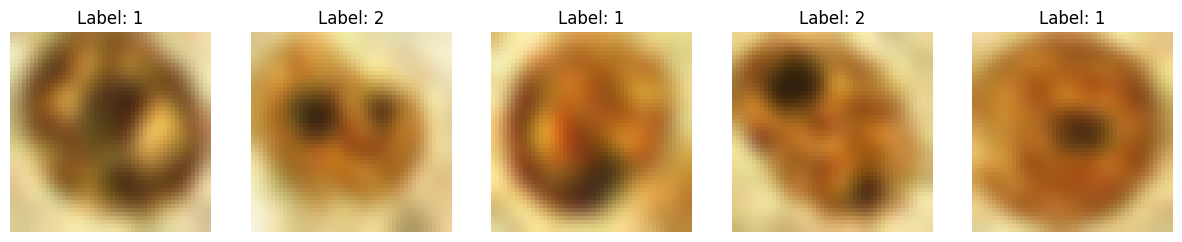

,filename,max_x,max_y,min_x,min_y,label
0,AgNOR_0495.tiff,26,41,4,15,1
1,AgNOR_0495.tiff,71,23,42,0,2
2,AgNOR_0495.tiff,133,61,104,37,1
3,AgNOR_0495.tiff,143,117,121,88,2
4,AgNOR_0495.tiff,224,37,199,12,1


In [5]:
df = pd.read_csv('annotation_frame.csv')
num_samples = len(df)
print("Number of samples in the dataset:", num_samples)

class CustomDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.classes = self.data['label'].unique()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.data.iloc[idx, 0])
        image = Image.open(img_name)
        label = self.data.iloc[idx, 5]
        min_x = self.data.iloc[idx, 3]
        min_y = self.data.iloc[idx, 4]
        max_x = self.data.iloc[idx, 1]
        max_y = self.data.iloc[idx, 2]
        
        image = image.crop((min_x, min_y, max_x, max_y))
        
        if self.transform:
            image = self.transform(image)
        else:
            image = transforms.ToTensor()(image)
        return image, label


def gaussian_blur(image, radius=2):
    image = transforms.ToPILImage()(image)
    return image.filter(ImageFilter.GaussianBlur(radius))

def colour_jitter(image, brightness=0, contrast=0, saturation=0, hue=0):
    #image = image.convert('HSV')
    image = ImageEnhance.Brightness(image).enhance(1 + brightness * random.uniform(-10, 20))
    image = ImageEnhance.Contrast(image).enhance(1 + contrast * random.uniform(-10, 20))
    image = ImageEnhance.Color(image).enhance(1 + saturation * random.uniform(-10, 20))
    image = image.convert('RGB')
    return image

transform = transforms.Compose([
    transforms.Resize((50, 50)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: gaussian_blur(x)),
    transforms.Lambda(lambda x: colour_jitter(x)),
])

dataset = CustomDataset(csv_file='annotation_frame.csv', root_dir='AgNORs', transform=transform)

def show_images(dataset, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i in range(num_images):
        idx = random.randint(0, len(dataset) - 1)
        image, label = dataset[idx]

        if isinstance(image, torch.Tensor):
            image = image.permute(1, 2, 0).numpy()
            image = image * 0.5 + 0.5
        else:
            pass

        axes[i].imshow(image)
        axes[i].set_title(f"Label: {label}")
        axes[i].axis('off')
    plt.show()

dataset = CustomDataset(csv_file='annotation_frame.csv', root_dir='AgNORs', transform=transform)
num_classes = len(dataset.classes)
print("Number of classes:", num_classes)

show_images(dataset)

df.head()

# Training/Validation/Test Split

After you have successfully created your dataset, you need to define a training, validation, and test split of the data. Split the images at the image level! Splits must not overlap!

1. Split the data.
2. Initialize a dataset for each split and pass it to a Pytorch dataloader.

In [6]:
unique_filenames = df['filename'].unique()
train_filenames, test_filenames = train_test_split(unique_filenames, test_size=0.3, random_state=42)
val_filenames, test_filenames = train_test_split(test_filenames, test_size=0.5, random_state=42)

train_indices = df[df['filename'].isin(train_filenames)].index.tolist()

train_indices = train_indices[:2]

val_indices = df[df['filename'].isin(val_filenames)].index.tolist()
test_indices = df[df['filename'].isin(test_filenames)].index.tolist()

train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)

def custom_collate(batch):
    images, labels = zip(*batch)
    images = [transforms.ToTensor()(img) for img in images]
    images = [transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(img) for img in images]
    return torch.stack(images), torch.tensor(labels)

#19864
batch_size = 1

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate)

print("Number of batches in train_loader:", len(train_loader))
print("Number of batches in val_loader:", len(val_loader))
print("Number of batches in test_loader:", len(test_loader))

for batch in train_loader:
    images, labels = batch
    print("Batch size:", images.size(0))
    break

Number of batches in train_loader: 2
Number of batches in val_loader: 3036
Number of batches in test_loader: 5013
Batch size: 1


# Initialise a classification model from pytorch.

For classification we will use a pre-trained model from pytorch. I would suggest an efficientnet_b0. Since we do not have too much training data and to mitigate overfitting, we will use ImageNet weights and only train the last layer. We will also freeze most of the network since we do not have much data and to save training time.

1. Load the model from torchvision [see](https://pytorch.org/vision/stable/models.html).
2. Load the respective weights.
3. Freeze all but the last layer.
4. If you have a gpu available, bring your model to the gpu.

In [7]:
model = models.efficientnet_b0(pretrained=True)
model.classifier = nn.Linear(1280,12)

for name, param in model.named_parameters():
    if "classifier" not in name:
        param.requires_grad = False
for name, param in model.named_parameters():
    if "classifier" in name:
        param.requires_grad = True

/Users/lizomander/Documents/python/.conda/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/lizomander/Documents/python/.conda/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Optimization Loop

a) The next step is the actual model optimization. But before we implement the training and validation loops, we need to initialize a loss function and an optimizer. We can use Adam as the optimizer and Cross Entropy Loss as the loss function from pytorch. We also need to set a learning rate for the model optimization.

1. Initialize a Loss Function
2. Initializing an Optimizer and Setting a Learning Rate


In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

b) Now, we will implement an optimization loop. First we implement the training phase. Implement a function (**train_one_epoch**) which performs the follwing steps.:

1. Define a variable running_loss in which you can store the change in loss during training. Since we will later chain the function with a validation function, bring the model to training mode if needed.
2. Iterate over your train dataloader, in each epoch you must:
    1. Transfer the tensors with the images and labels to the GPU or CPU, depending on the device on which your model is located.
    2. Delete the old gradients in the optimizer.
    3. Perform the actual forward pass, i.e. pass the images to the model and calculate the predictions (model(imgs))
    4. Calculate the loss
    5. Backpropagate the loss (loss.backward())
    6. Perform the optimization step (optimizer.stepp())
    7. Add the loss of the current batch to your running_loss
    8. Print the loss every x batches, also return the average loss of the epoch

**Tip:** use **[tqdm.notebook.tqdm](https://tqdm.github.io/docs/notebook/)** to visualize the progress during the epoch.

In [9]:
def train_one_epoch(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc="Training", leave=False):
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    return epoch_loss

c) We also need a validation loop, which is called after a training loop to determine the training progress on the validation data. Implement this in a function (**validate_one_epoch**). This loop looks very similar to the training loop, but we can skip the backpropagation here. Also, use a metric from Torchmetrics to measure the performance of your models. The validation function should also return the loss or the metric so you can use it to select the best model during training.

1. Turn off gradient storage. Put your model in evaluation mode. Since there is no backpropagation in the validation, we do not need it and can save a lot of memory.
2. As with the training loop, iterate over the validation data loader and perform a forward pass in each epoch.
3. Compute a loss in each epoch, but not backpropagated
4. Store and output the loss and return the average loss of the epoch
5. Update your metric with the predictions and labels of each batch
6. Calculate your metric after the last batch.


In [10]:
def validate_one_epoch(model, val_loader, criterion):
    running_loss = 0.0
    running_f1 = 0.0
    total_samples = 0
    model.eval()
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validation", leave=False):
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            running_f1 += compute_f1_score(outputs, labels) * images.size(0)
            total_samples += images.size(0)
    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_f1 = running_f1 / total_samples
    return epoch_loss, epoch_f1

d) Combine training and validation in an optimization loop. This loop is run **n_epochs** times. In each iteration, first call your training function and then your validation function. In each epoch, check to see if your model has improved, and if so, save the model. Do not save a new checkpoint in each epoch, as this will consume too much memory. Save the losses of the training and validation functions over the epochs to plot them at the end of your training. If you do not have a GPU available, you do not need to train your model to convergence. Just train a few steps.

Epoch [1/10], Train Loss: 2.3725, Validation Loss: 2.4900, Validation F1 Score: 0.0316


Epoch [2/10], Train Loss: 1.8719, Validation Loss: 2.4603, Validation F1 Score: 0.0363


Epoch [3/10], Train Loss: 1.3274, Validation Loss: 2.4508, Validation F1 Score: 0.0337


Epoch [4/10], Train Loss: 0.8239, Validation Loss: 2.4564, Validation F1 Score: 0.0377


Epoch [5/10], Train Loss: 0.5155, Validation Loss: 2.4792, Validation F1 Score: 0.0359


Epoch [6/10], Train Loss: 0.3425, Validation Loss: 2.4935, Validation F1 Score: 0.0390
Early stopping after epoch 6


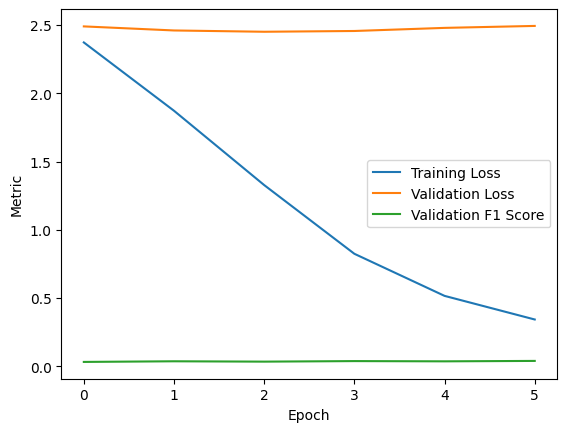

In [11]:
def train_one_epoch(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc="Training", leave=False):
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    return epoch_loss

def validate_one_epoch(model, val_loader, criterion, metric):
    running_loss = 0.0
    metric.reset()
    model.eval()
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validation", leave=False):
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            metric.update(outputs, labels)
    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_metric = metric.compute() 
    return epoch_loss, epoch_metric

def compute_f1_score(n_classes:int = 12, num_labels:int = 12):
    f1 = F1Score(num_classes = n_classes, num_labels = num_labels, average='macro', task = 'multiclass')
    return f1

def optimisation_loop(model, train_loader, val_loader, criterion, optimizer, n_epochs, model_path):
    train_losses = []
    val_losses = []
    f1_scores = []
    best_val_loss = float('inf')  
    patience = 3  
    epochs_without_improvement = 0  

    for epoch in range(n_epochs):
        train_loss = train_one_epoch(model, train_loader, criterion, optimizer)
        train_losses.append(train_loss)

        val_loss, val_f1_score = validate_one_epoch(model, val_loader, criterion, compute_f1_score(num_labels=12, n_classes = 12))
        val_losses.append(val_loss)
        f1_scores.append(val_f1_score)

        if val_loss < best_val_loss: 
            best_val_loss = val_loss
            torch.save(model.state_dict(), model_path)
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        print(f'Epoch [{epoch+1}/{n_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation F1 Score: {val_f1_score:.4f}')

        if epochs_without_improvement >= patience:
            print(f'Early stopping after epoch {epoch+1}')
            break

    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.plot(f1_scores, label='Validation F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('Metric')
    plt.legend()
    plt.show()

n_epochs = 10

optimisation_loop(model, train_loader, val_loader, criterion, optimizer, n_epochs, 'best_model.pth')

# Model testing

Once the optimization is complete, you can test your model on the test data. This means that you apply your model to the images in your dataset. To do this, iterate over all instances in your test data set.

1. Initialize the best performing model.
2. Initialize the F1 score metric from TorchVision.
3. Iterate over all instances in the test dataset and update your metric after each batch.
4. Compute the final metric.

In [12]:
def model_testing(model, test_loader, device, model_path, num_classes):
    print("Model path:", model_path)
    model.load_state_dict(torch.load(model_path))
    model.eval()

    f1_metric = torchmetrics.F1Score(task = 'multiclass', num_classes=num_classes, num_labels = num_classes)

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            
            f1_metric.update(outputs, labels)

    final_f1_score = f1_metric.compute()

    return final_f1_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_classes = 12
final_f1_score = model_testing(model, test_loader, device, 'best_model.pth', num_classes)
print("Final F1 Score:", final_f1_score)


/var/folders/1h/ztvq2n792s13rt0zn20wh3vc0000gn/T/ipykernel_88230/634626195.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Model path: best_model.pth
Final F1 Score: tensor(0.0870)
